# Dataloader for Contrastive Loss

This notebook implements the dataloader needed for training the Siamese network later.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" #to suppress some unnecessary warnings
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from Utilities import DataLoaderContrastive, get_dataset_with_prefetching

## Scan the directories of the dataset

In [6]:
dataset_root_path = "lfw_funneled"
multi_image_classes_paths = []   # paths of classes with two or more images
single_image_classes_paths = []  # paths of classes with only one images

# scan
for class_dir in os.scandir(dataset_root_path):
    files = os.listdir(class_dir.path)
    
    if len(files) > 1:
        # this path contains more than one file (image) of the same class (person)
        multi_image_classes_paths.append([])
        for file in files:
            multi_image_classes_paths[-1].append(os.path.join(class_dir.path, file))
    else:
        # this path conatins only one file (image) of the same class (person)
        single_image_classes_paths.append([])
        single_image_classes_paths[-1].append(os.path.join(class_dir.path, files[0]))

print(f"{len(multi_image_classes_paths)} classes with two or more images")
print(f"{len(single_image_classes_paths)} classes with only one image")

1680 classes with two or more images
4069 classes with only one image


## Display a sample batch

input batch shape is (2, 250, 250, 3)
output batch shape is (4, 1)
label is : 1.0


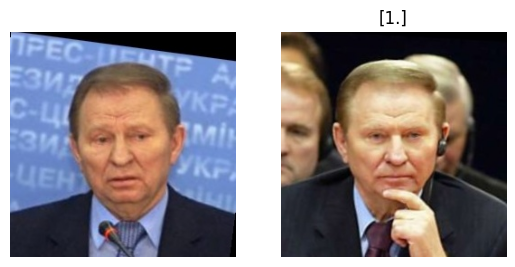

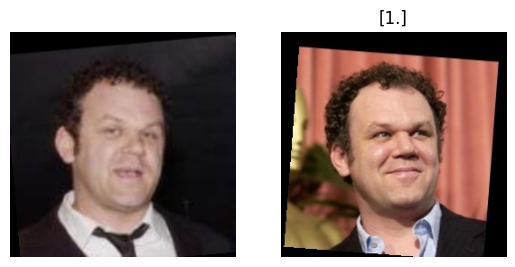

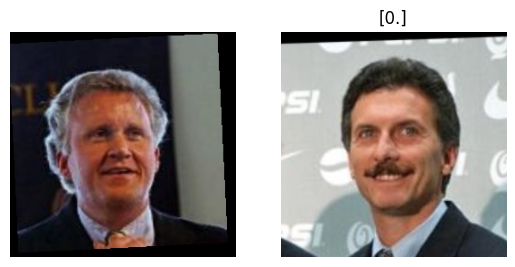

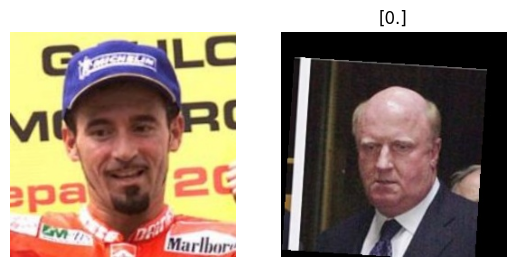

In [3]:
train_loader = DataLoaderContrastive(dataset_root_path=dataset_root_path, batch_size=4, input_shape=(250, 250))

# get sample batch
(X1, X2), Y = train_loader[random.randint(0, len(train_loader)-1)]

# get sample pair
x1 = X1[0]
x2 = X2[0]
y_label = Y[0]

print(f"input batch shape is {np.concatenate([[x1], [x2]], axis = 0).shape}")
print(f"output batch shape is {Y.shape}")
print(f"label is : {y_label[0]}")

# show the whole batch
for i in range(len(X1)):

    x1 = X1[i]
    x2 = X2[i]
    y_label = Y[i]

    plt.figure(i)

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(x1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(x2)

    plt.title(y_label)

plt.show()

## Test on Real Example

In [7]:
Input1 = keras.layers.Input(shape = (250, 250, 3))
Input2 = keras.layers.Input(shape = (250, 250, 3))
flatten1 = keras.layers.Flatten()(Input1)
flatten2 = keras.layers.Flatten()(Input2)
feature_vector = keras.layers.Concatenate()([flatten1, flatten2])
clf_head = keras.layers.Dense(32, 'relu')(feature_vector)
output = keras.layers.Dense(1, 'sigmoid')(clf_head)

model = keras.Model(inputs = [Input1, Input2], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [9]:
train_loader = DataLoaderContrastive(dataset_root_path=dataset_root_path, batch_size=32, input_shape=(250, 250))

model.fit(train_loader, epochs = 2)

Epoch 1/2


105/105 [==============================] - 204s 2s/step - loss: 3.6013 - accuracy: 0.5018
Epoch 2/2
105/105 [==============================] - 128s 1s/step - loss: 0.6931 - accuracy: 0.5000


Test the model on an example:

In [24]:
# sample random batch
(X1, X2), y = train_loader[random.randint(0, len(train_loader))]

# sample random pair
n = random.randint(0, X1.shape[0])
x1, x2, y = X1[n], X2[n], y[n]

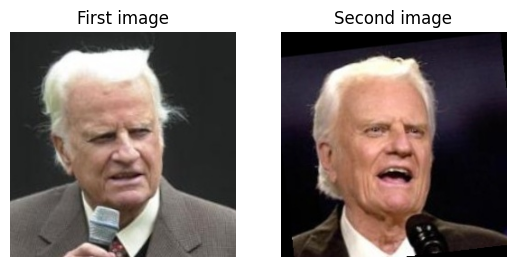

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

In [27]:
y = model.predict(x = [np.expand_dims(x1, axis = 0), np.expand_dims(x2, axis = 0)])

print(y)

1/1 [==============================] - 0s 33ms/step
[[0.5005771]]


## Optimize the data loader using tensorflow prefetching

In [ ]:
#This is how to turn the regular dataloader into a tensorflow dataset with prefetching enabled
#
# dataset = tf.data.Dataset.from_generator(
#         DataLoader, 
#         args = [dataset_root_path, 32, (250, 250)], 
#         output_signature = ((tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32), tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32)), tf.TensorSpec(shape = (32, 1), dtype = tf.float32))
# ).prefetch(tf.data.AUTOTUNE)


#Use the function implemented in the Utilities file instead
dataset = get_dataset_with_prefetching(dataset_root_path, 512)
model.fit(dataset, epochs = 3)

Epoch 1/3
105/105 [==============================] - 64s 605ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 2/3
105/105 [==============================] - 73s 676ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 3/3
105/105 [==============================] - 50s 463ms/step - loss: 0.6931 - accuracy: 0.5000
